In [106]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Replace `path` with directory where your `face_images` were downloaded. Available on [Google drive](https://drive.google.com/file/d/1yCYa3IvsvYTkjkl4bvs96pWQfcgOJpxu/view?usp=sharing)

In [107]:
import os, random
path = '/home/nonsodono/Documents/face_images'
os.chdir(path)  

### Converting Data to Fastai's `DataBlock` objects.

In [108]:
!pip3 install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.widgets import *

In [109]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.15, seed=42),
    get_y=parent_label
    )

In [110]:
dls = faces.dataloaders(path)

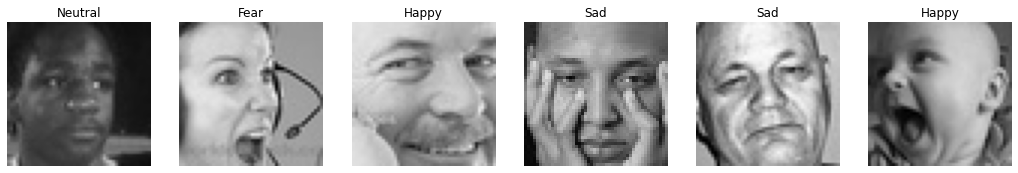

In [111]:
dls.train.show_batch(max_n=6, nrows=1)

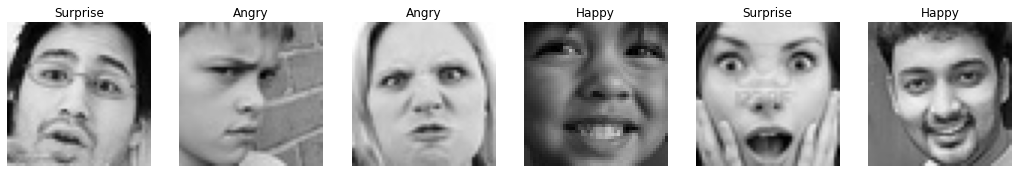

In [112]:
dls.valid.show_batch(max_n=6, nrows=1)

### Data Augmentation

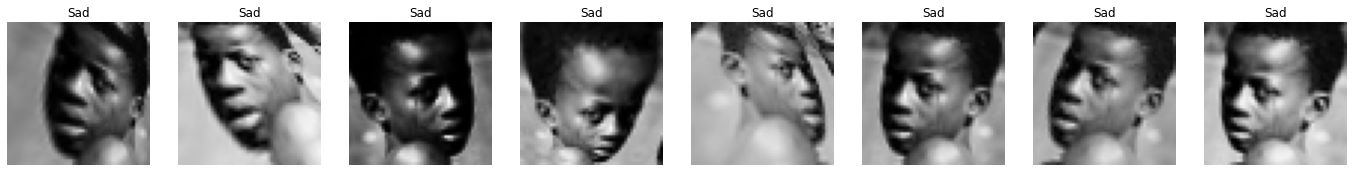

In [113]:
faces = faces.new(item_tfms=Resize(48), batch_tfms=aug_transforms(mult=2))
dls = faces.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

### Training the model using Fastai and `vgg19_bn` pretrained model

In [114]:
model = cnn_learner(dls, vgg19_bn, metrics=accuracy)
model.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.041682,1.762459,0.338918,00:34


epoch,train_loss,valid_loss,accuracy,time
0,1.587587,1.348190,0.486118,00:49
1,1.338572,1.167013,0.547152,00:50
2,1.204634,1.066465,0.598133,00:50
3,1.108670,1.029040,0.614648,00:51
4,1.052150,0.950291,0.633796,00:51
5,0.981733,0.901125,0.654380,00:51
6,0.917765,0.898854,0.652944,00:51
7,0.865178,0.872840,0.670656,00:51
8,0.825799,0.859390,0.674964,01:57
9,0.803406,0.860699,0.677836,02:47


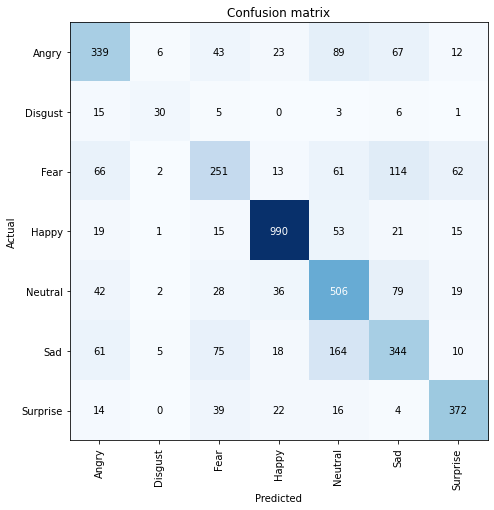

In [115]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix(figsize=(7,7))

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=2.75422871709452e-06)

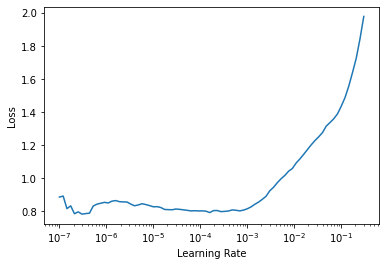

In [121]:
model.lr_find()

In [124]:
model.unfreeze()
model.fine_tune(5, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.832825,0.881381,0.673289,00:37


epoch,train_loss,valid_loss,accuracy,time
0,0.837389,0.878526,0.675443,00:50
1,0.859191,0.888876,0.667544,00:50
2,0.832682,0.871822,0.674725,00:51
3,0.756617,0.874194,0.676161,00:51
4,0.748108,0.878199,0.675682,00:51


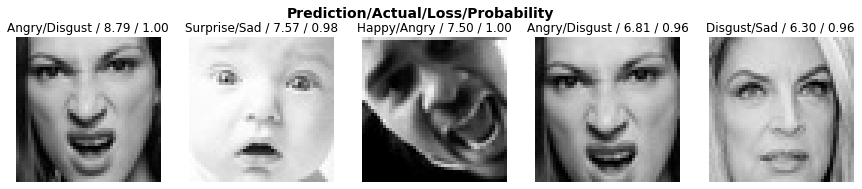

In [125]:
interp.plot_top_losses(5, nrows=1)

### Cleaning the data based on loss data.

In [126]:
cleaner = ImageClassifierCleaner(model)
cleaner

In [127]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

### Exporting the model 

In [128]:
model.export()

In [129]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Make `inferences` from the loaded model

In [130]:
model_inf = load_learner(path/'export.pkl')

In [131]:
# Show classes in the model
model_inf.dls.vocab

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

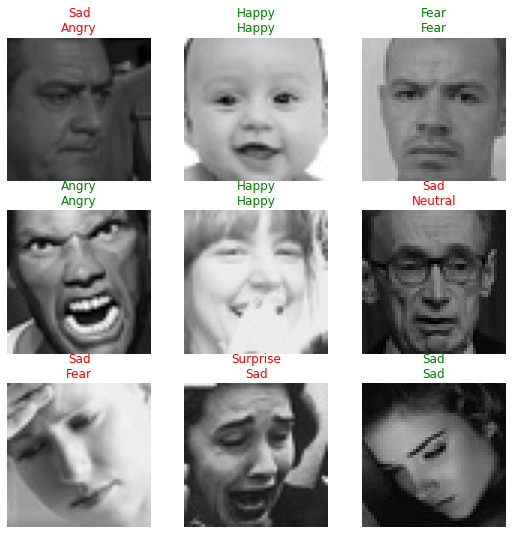

In [132]:
model.show_results()

In [133]:
### Add widgets to upload and classify example images

In [134]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = model_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [135]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your face!'), 
      btn_upload, btn_run, out_pl, lbl_pred])